# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) [github link](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py). We refer to this VAE as the "Example VAE" in this notebook.

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


thingi = Thingi10k.init10k(pctile=.8)
# apply filter
#thingi.filter_by_id(1351747)
thingi.filter_by_tag('animal')
#thingi.filter_to_just_one()
#thingi = Thingi10k.init10()
#thingi = Thingi10k.init10(pctile=.1)
n_input = len(thingi)
n_input

109

In [20]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, debug=False, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.debug = debug
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        # add ops to this list as a tuple with (<op name>, <op>) to see them executed, returned, and printed
        # to console during execution
        self._debug_ops = list()
        
        # Construct the TensorFlow Graph
        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        
        self.D_real, self.D_real_logits = self._discriminator(self._input_x, self._trainable)
        self.D_fake, self.D_fake_logits = self._discriminator(self.decoder, self._trainable)
        
        ################### add mashup  ##################################
#         self._input_1 = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._input_x2 = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        # initialize the weight, perhaps can use other initializer???
        self._weight = tf.Variable(np.random.rand(self.input_dim, self.input_dim, self.input_dim,1), dtype=tf.float32)
#         self._weight = tf.expand_dims(self._weight, 0)
    
        # shall i generate batch of pair or two batches??
        self._mashup = self._weight * self._input_x + (1 - self._weight) * self._input_x2
        self._mashup = tf.cast(self._mashup, tf.float32)
        # for real probability, we only calculate the 1st object of the pair
#         self.D_real_mashup, self.D_real_logits_mashup = self._discriminator(self._input_x, self._trainable)
        self.D_fake_mashup, self.D_fake_logits_mashup = self._discriminator(self._mashup, self._trainable)
        
        # GAN loss for mashup
        self.D_loss_mashup, self.G_loss_mashup, self.D_optim_mashup, self.G_optim_mashup = self._make_GAN_loss(self.D_real_logits
                                                                                                               , self.D_fake_logits_mashup)
        
        #######################################################################
        
        # VAE loss
        self.loss, self.optimizer, self.mean_recon, self.mean_kl = self._make_loss(self._input_x, self.decoder
                                                                                   , self.enc_mu, self.enc_sig)
        # GAN loss
        self.D_loss, self.G_loss, self.D_optim, self.G_optim = self._make_GAN_loss(self.D_real_logits, self.D_fake_logits)
    
    
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons_pre = list()
        self.recons_post = list()
        self.losses_kl_div = list()
        self.losses_recon = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
            # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
            # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
            conv1 = tf.layers.batch_normalization(tf.layers.conv3d(input_x,
                                     filters=8,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv1)
            # the Example VAE specifies the activation functions as part of the layer
            # we specify the activation function as a seperate tensor
            # it is unknown if this is the preferred method in Tensorflow, but we know
            # it works from work in the 3D-VAE-GAN notebook
            # we also take advantage of batch_normalization
            # more info here:
            # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
            # with the hope that it gives speed without sacrificing quality
            # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
            # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu

            conv2 = tf.layers.batch_normalization(tf.layers.conv3d(conv1,
                                     filters=16,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv2)

            conv3 = tf.layers.batch_normalization(tf.layers.conv3d(conv2,
                                     filters=32,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv3)

            conv4 = tf.layers.batch_normalization(tf.layers.conv3d(conv3,
                                     filters=64,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv4)

            # Apply one fully-connected layer after Conv3d layers
            # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
            dense1 = tf.layers.batch_normalization(tf.layers.dense(conv4,
                                 units=343,
                                 activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(dense1)
            flatten = tf.layers.flatten(tf.nn.dropout(dense1, keep_prob))
        
            enc_mu = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_mu)
            enc_sig = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_sig)
                                                  
            # epsilon is a random draw from the latent space
            epsilon = tf.random_normal(tf.stack([tf.shape(dense1)[0], self.latent_dim]))
            self._print_shape(epsilon, 'epsilon')
            enc_z = enc_mu + tf.multiply(epsilon, tf.exp(enc_sig))
            self._print_shape(enc_z, 'z')
        return enc_z, enc_mu, enc_sig


        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')

        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')

        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable): ## generator
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
            self._print_shape(input_z, 'input_z')

            # Why conv3d_transpose instead of conv3d?
            #
            # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
            #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
            #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
            #
            # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
            dense1 = tf.layers.dense(input_z,
                                     units=343,
                                     kernel_initializer=tf.initializers.glorot_uniform(),
                                     name='dec_dense1')
            self._print_shape(dense1)
            lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
            self._print_shape(lrelu1)

            #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
            reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
            self._print_shape(reshape_z)
            #print('reshape_z: ', reshape_z.shape)
            #for value in reshape_z.shape:
            #    print(type(value))

            conv1 = tf.layers.conv3d_transpose(reshape_z,
                                               filters=64,
                                               kernel_size=[3, 3, 3],
                                               strides=(1, 1, 1),
                                               padding='same',
                                               # Example VAE does not mention bias
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv1')
            self._print_shape(conv1)
            lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
            self._print_shape(lrelu2)

            conv2 = tf.layers.conv3d_transpose(lrelu2,
                                               filters=32,
                                               kernel_size=[3, 3, 3],
                                               # Example VAE used .5 stride values, but Tensorflow complains
                                               # of being forced to use a float value here
                                               #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                               strides=(2, 2, 2),
                                               padding='valid',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv2')
            self._print_shape(conv2)
            lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
            self._print_shape(lrelu3)

            conv3 = tf.layers.conv3d_transpose(lrelu3,
                                               filters=16,
                                               kernel_size=[3, 3, 3],
                                               strides=(1, 1, 1),
                                               # changed to valid to hit correct dimension
                                               padding='same',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv3')
            self._print_shape(conv3)
            lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
            self._print_shape(lrelu4)

            conv4 = tf.layers.conv3d_transpose(lrelu4,
                                               filters=8,
                                               kernel_size=[4, 4, 4],
                                               #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                               strides=(2, 2, 2),
                                               padding='valid',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv4')
            self._print_shape(conv4)
            lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
            self._print_shape(lrelu5)

            conv5 = tf.layers.conv3d_transpose(lrelu5,
                                               filters=1,
                                               kernel_size=[3, 3, 3],
                                               strides=(1, 1, 1),
                                               padding='same',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv5')
            self._print_shape(conv5)
            #decoded_output = tf.nn.tanh(conv5)
            decoded_output = tf.nn.sigmoid(conv5)
            #decoded_output = tf.clip_by_value(decoded_output, 1e-7, 1.0 - 1e-7)
            #self._add_debug_op('max decoded_output', tf.math.reduce_max(decoded_output), False)
            #self._add_debug_op('min decoded_output', tf.math.reduce_min(decoded_output), False)
            #self._add_debug_op('mean decoded_output', tf.math.reduce_mean(decoded_output), False)
            #decoded_output = conv5
            self._print_shape(decoded_output)

        return decoded_output
    
    ## add discriminator, GAN
    def _discriminator(self, input_x, trainable):
        # need to clip the values?
        with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):

           # need to clip the values?
            self._print_shape(input_x, 'input_x')

            # 1st hidden layer
            conv1 = tf.layers.conv3d(input_x, 128, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
            lrelu1 = tf.nn.elu(conv1)
            self._print_shape(lrelu1)

            # 2nd hidden layer
            conv2 = tf.layers.conv3d(lrelu1, 256, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
            lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable))
            self._print_shape(lrelu2)

            # 3rd hidden layer
            conv3 = tf.layers.conv3d(lrelu2, 512, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
            lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable))
            self._print_shape(lrelu3)
            
            # output layer
            #conv4 = tf.layers.conv3d(lrelu3, 1, [4, 4, 4], strides=(1, 1, 1), padding='valid', use_bias=False,
            #                          kernel_initializer=tf.contrib.layers.xavier_initializer())
            conv4 = tf.layers.conv3d(lrelu3, 1, [4, 4, 4], strides=(1, 1, 1), padding='valid', use_bias=False,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
            o = tf.nn.sigmoid(conv4)
            self._print_shape(conv4)
            self._print_shape(o)
            
        return o, conv4
    
    
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        # we must clip because values of 0 or 1 will cause errors
        #clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        clipped_input = tf.clip_by_value(enc_input, 1e-7, 1.0 - 1e-7)
        clipped_output = tf.clip_by_value(dec_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max clipped_input', tf.math.reduce_max(clipped_input), False)
        #self._add_debug_op('min clipped_input', tf.math.reduce_min(clipped_input), False)
        #self._add_debug_op('mean clipped_input', tf.math.reduce_mean(clipped_input), False)
        self._add_debug_op('max clipped_output', tf.math.reduce_max(clipped_output), False)
        self._add_debug_op('min clipped_output', tf.math.reduce_min(clipped_output), False)
        self._add_debug_op('mean clipped_output', tf.math.reduce_mean(clipped_output), False)
        bce = -(98.0 * clipped_input * tf.log(clipped_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - clipped_output)) / 100.0
        #self._add_debug_op('bce', bce, False)
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce, 1)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_kl = tf.reduce_sum(kl_divergence)
        #self._add_debug_op('mean_kl', mean_kl, False)
        mean_recon = tf.reduce_sum(recon_loss)
        #self._add_debug_op('mean_recon', mean_recon, False)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        #self._add_debug_op('loss', loss, False)
        # remove kl for fun
        #loss = tf.reduce_mean(self.recon_loss_weight * recon_loss)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

        return loss, optimizer, mean_recon, mean_kl
    
#     # some example use D_real not logits in loss function
#     def _make_GAN_loss(self, D_real, D_fake):

#         D_loss_real = tf.reduce_mean(D_real)
#         D_loss_fake = tf.reduce_mean(D_fake)
#         D_loss = D_loss_real - D_loss_fake
#         G_loss = -tf.reduce_mean(D_fake)
        
#         D_optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(-D_loss)
#         G_optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(G_loss)
        
#         return D_loss, G_loss, D_optim, G_optim
    
    def _make_GAN_loss(self, D_real_logits, D_fake_logits):

        D_loss_real = tf.reduce_mean(D_real_logits)
        D_loss_fake = tf.reduce_mean(D_fake_logits)
        D_loss = D_loss_real - D_loss_fake
        G_loss = -tf.reduce_mean(D_fake_logits)
        
        D_optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(-D_loss)
        G_optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(G_loss)
        
        return D_loss, G_loss, D_optim, G_optim
    
    def _add_debug_op(self, name, op, newline=True):
        self._debug_ops.append((name, op, newline))
        return

    def _print_debug_ops(self, results):
        if self.debug:
            for i, debug_op in enumerate(self._debug_ops):
                msg = 'DEBUG_OP "{}": '.format(debug_op[0])
                if len(debug_op) > 2 and debug_op[2]:
                    msg += '\n'
                msg += '{}'.format(results[i])
                print(msg)
        return

    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

#                     sess.run(self.D_optim, feed_dict={x_encoder_in: batch, x_discr_in: batch, keep_prob: 0.8, isTrain: True})
#                     sess.run(clip)

                    ops = tuple([self.optimizer, self.loss, self.mean_kl, self.mean_recon
                                 , self.D_loss, self.G_loss, self.D_optim, self.G_optim] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    _, loss, kl_divergence, recon_loss, D_loss, G_loss, _, _ = results[:8]
                    self._print_debug_ops(results[8:])                   
                    
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\tKL Divergence = {}, Reconstruction Loss = {}, -D_loss = {}, G_loss = {}'.format(kl_divergence
                                                                                                , recon_loss, -D_loss, G_loss))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "-D_Loss = {:.5f}, ".format(-D_loss) +
                      "G_Loss = {:.5f}, ".format(G_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                if viz_data is None:
                    viz_data = batch[0]
                self._print_shape(viz_data, 'Example shape (before reshape)')
                recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
                self._print_shape(recon_input, 'Example shape')
                
                # generate!
                recon = self.reconstruct(recon_input)
                self._print_shape(recon, 'Recon')

                # prepare for plotting
                recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon_input, 'Example shape (for plotting)')
                recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon, 'Recon (for plotting)')
                # network outputs decimals; here we force them to True/False for plotting
                self.recons_pre.append(recon)
                recon = recon > 0.5
                self.recons_post.append(recon)
                # replace all nans with zeros
                #recon = np.nan_to_num(recon)
                
                # save the generated object in case we wish to review later
                path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

                # visualize
                self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))

                print("Model saved in path: {}".format(save_path))
                                       
        return
    #################use a separate train proce for mashup #############################3
    def train_2(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, (batch_1, batch_2) in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

#                     sess.run(self.D_optim, feed_dict={x_encoder_in: batch, x_discr_in: batch, keep_prob: 0.8, isTrain: True})
#                     sess.run(clip)

                    ops = tuple([self.D_loss_mashup, self.G_loss_mashup, self.D_optim_mashup, self.G_optim_mashup] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch_1, self._input_x2: batch_2
                                   , self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    D_loss_mashup, G_loss_mashup, _, _ = results[:4]
                    self._print_debug_ops(results[4:])                   
                    
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\t-D_loss_mashup = {}, G_loss_mashup = {}'.format(-D_loss_mashup, G_loss_mashup))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "-D_Loss_mashup = {:.5f}, ".format(-D_loss_mashup) +
                      "G_Loss_mashup = {:.5f}, ".format(G_loss_mashup) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
#                 print('Generation Example:')
                
#                 # prepare for generation
#                 #print(batch[0][0])
#                 if viz_data is None:
#                     viz_data = batch[0]
#                 self._print_shape(viz_data, 'Example shape (before reshape)')
#                 recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
#                 self._print_shape(recon_input, 'Example shape')
                
#                 # generate!
#                 recon = self.reconstruct(recon_input)
#                 self._print_shape(recon, 'Recon')

#                 # prepare for plotting
#                 recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
#                 self._print_shape(recon_input, 'Example shape (for plotting)')
#                 recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
#                 self._print_shape(recon, 'Recon (for plotting)')
#                 # network outputs decimals; here we force them to True/False for plotting
#                 self.recons_pre.append(recon)
#                 recon = recon > 0.5
#                 self.recons_post.append(recon)
#                 # replace all nans with zeros
#                 #recon = np.nan_to_num(recon)
                
#                 # save the generated object in case we wish to review later
#                 path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

#                 # visualize
#                 self.visualize_reconstruction(recon_input, recon)

#             if (epoch + 1) % save_step == 0:
#                 # Save the variables to disk.
#                 save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))

#                 print("Model saved in path: {}".format(save_path))
                                      
        return
    ##########################################33333
    
    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.decoder] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        
        decoded = results[0]
        self._print_debug_ops(results[1:])
                    
        return decoded
    
    ############add mashup function#############################3
    def mashup(self, input_1, input_2):
        
        ops = tuple([self._mashup] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_1, self._input_x2: input_2, self._keep_prob: 1.0, self._trainable: False})
        
        mashed = results[0]
        self._print_debug_ops(results[1:])
                    
        return mashed
    ######################################################
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon
* Equalized loss weights yielded no change (at 100 epochs on one square example with 50 input_repeats, viz was all 1s)
* By dumping out counts of True vs False of each recon, I can see that False goes down while True goes up to the point where they are almost all Trues after 50 epochs
* Run through all training examples produces loss of nan
* Added homebaked debug_ops and discovered that the dec_output is nan and not the loss functions!

Num input = 109
Num batches per epoch = 4.95


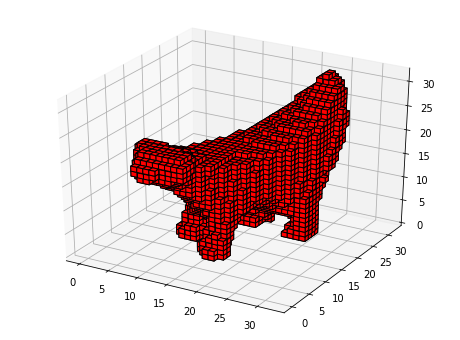

In [4]:
VOXELS_DIM = 32
BATCH_SIZE = 22
print('Num input = {}'.format(n_input))
print('Num batches per epoch = {:.2f}'.format(n_input / BATCH_SIZE))
training_example = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=101902))
plot_voxels(training_example)

In [11]:
generator = lambda: thingi.voxels_batchmaker_2(batch_size=10, voxels_dim=32, verbose=False)
for j, (i_1, i_2) in enumerate(generator()):
    print(j, i_1.shape, i_2.shape)
    break

0 (10, 32, 32, 32, 1) (10, 32, 32, 32, 1)


In [21]:
tf.reset_default_graph()

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=100,
                                 learning_rate=0.0001, # 0.00005 for D_lr
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1e4,
                                 verbose=True,
                                 debug=True)

#     generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)
#     vae.train(generator, epochs=10, input_repeats=1, display_step=1, save_step=100,
#              viz_data=training_example)
    generator_2 = lambda: thingi.voxels_batchmaker_2(batch_size=1, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train_2(generator_2, epochs=10, input_repeats=1, display_step=1, save_step=100)
except Exception as exc:
    vae.close()
    raise(exc)

encoder/batch_normalization/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_6/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
generator/dec_dense1/BiasAdd:0: (?, 343)
generator/Elu:0: (?, 343)
generator/reshape_z:0: (?, 7, 7, 7, 1)
generator/dec_conv1/conv3d_transpose:0: (?, 7, 7, 7, 64)
generator/dec_lrelu2:0: (?, 7, 7, 7, 64)
generator/dec_conv2/conv3d_transpose:0: (?, 15, 15, 15, 32)
generator/dec_lrelu3:0: (?, 15, 15, 15, 32)
generator/dec_conv3/conv3d_transpose:0: (?, 15, 15, 15, 16)
generator/dec_lrelu4:0: (?, 15, 15, 15, 16)
generator/dec_conv4/conv3d_transpose:0: (?, 32, 32, 32, 8)
generator/dec_lrelu5:0: (?, 

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 0.3091087341308594, G_loss_mashup = -56.57282638549805
Epoch: 0, Batch: 30, Elapsed time: 0.24 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 29.12287139892578, G_loss_mashup = -66.95365142822266
Epoch: 0, Batch: 31, Elapsed time: 0.25 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 16.977521896362305, G_loss_mashup = -23.897674560546875
Epoch: 0, Batch: 32, Elapsed time: 0.26 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 1.0153884887695312, G_loss_mashup = -55.46661376953125
Epoch: 0, Batch: 33, Elapsed time: 0.27 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 8.560676574707031, G_loss_mashup = -122.2346420288086
Epoch: 1, Batch: 13, Elapsed time: 0.59 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 9.606216430664062, G_loss_mashup = -119.25811767578125
Epoch: 1, Batch: 14, Elapsed time: 0.60 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 15.926506042480469, G_loss_mashup = -110.49242401123047
Epoch: 1, Batch: 15, Elapsed time: 0.61 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 2.9345550537109375, G_loss_mashup = -131.6942138671875
Epoch: 1, Batch: 16, Elapsed time: 0.62 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 42.061317443847656, G_loss_mashup = -115.89334106445312
Epoch: 1, Batch: 50, Elapsed time: 0.94 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 6.698211669921875, G_loss_mashup = -171.34547424316406
Epoch: 1, Batch: 51, Elapsed time: 0.95 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 0.187164306640625, G_loss_mashup = -181.52622985839844
Epoch: 1, Batch: 52, Elapsed time: 0.96 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 3.1316375732421875, G_loss_mashup = -189.30575561523438
Epoch: 1, Batch: 53, Elapsed time: 0.97 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -16.102279663085938, G_loss_mashup = -204.97998046875
Epoch: 2, Batch: 33, Elapsed time: 1.30 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 21.182907104492188, G_loss_mashup = -249.7747344970703
Epoch: 2, Batch: 34, Elapsed time: 1.31 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 7.1706085205078125, G_loss_mashup = -229.8058624267578
Epoch: 2, Batch: 35, Elapsed time: 1.31 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 38.94996643066406, G_loss_mashup = -241.2644500732422
Epoch: 2, Batch: 36, Elapsed time: 1.32 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5


DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -7.38238525390625, G_loss_mashup = -306.8544921875
Epoch: 3, Batch: 16, Elapsed time: 1.65 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 55.102020263671875, G_loss_mashup = -283.55523681640625
Epoch: 3, Batch: 17, Elapsed time: 1.65 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -28.934326171875, G_loss_mashup = -278.7864990234375
Epoch: 3, Batch: 18, Elapsed time: 1.66 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 0.9517822265625, G_loss_mashup = -295.4310607910156
Epoch: 3, Batch: 19, Elapsed time: 1.67 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_lo

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -4.159088134765625, G_loss_mashup = -381.81243896484375
Epoch: 3, Batch: 53, Elapsed time: 1.99 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -4.51715087890625, G_loss_mashup = -379.75616455078125
Epoch: 4, -D_Loss_mashup = -4.51715, G_Loss_mashup = -379.75616, Elapsed time: 2.00 mins
Epoch: 4, Batch: 0, Elapsed time: 2.00 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -1.64349365234375, G_loss_mashup = -375.4919738769531
Epoch: 4, Batch: 1, Elapsed time: 2.01 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -6.2109375, G_loss_mashup = -387.4985656738281
Epoch: 4, Batch: 2, Elapsed time: 2.02 mins
DEBUG_OP "max clipped_outp

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 34.35589599609375, G_loss_mashup = -449.5263977050781
Epoch: 4, Batch: 36, Elapsed time: 2.35 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -1.239990234375, G_loss_mashup = -445.40093994140625
Epoch: 4, Batch: 37, Elapsed time: 2.36 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -16.739044189453125, G_loss_mashup = -440.2925720214844
Epoch: 4, Batch: 38, Elapsed time: 2.37 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 11.242584228515625, G_loss_mashup = -468.2882995605469
Epoch: 4, Batch: 39, Elapsed time: 2.37 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5


DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -10.51837158203125, G_loss_mashup = -503.97113037109375
Epoch: 5, Batch: 19, Elapsed time: 2.70 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 2.862548828125, G_loss_mashup = -533.4600830078125
Epoch: 5, Batch: 20, Elapsed time: 2.71 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 30.5799560546875, G_loss_mashup = -538.6104125976562
Epoch: 5, Batch: 21, Elapsed time: 2.72 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -12.76519775390625, G_loss_mashup = -538.6692504882812
Epoch: 5, Batch: 22, Elapsed time: 2.72 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -20.51422119140625, G_loss_mashup = -595.087158203125
Epoch: 6, Batch: 2, Elapsed time: 3.07 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 8.55792236328125, G_loss_mashup = -612.7218627929688
Epoch: 6, Batch: 3, Elapsed time: 3.08 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -21.55584716796875, G_loss_mashup = -604.8170776367188
Epoch: 6, Batch: 4, Elapsed time: 3.10 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 47.75360107421875, G_loss_mashup = -632.9962768554688
Epoch: 6, Batch: 5, Elapsed time: 3.11 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_lo

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 1.61175537109375, G_loss_mashup = -710.2642822265625
Epoch: 6, Batch: 39, Elapsed time: 3.51 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -2.9334716796875, G_loss_mashup = -716.5905151367188
Epoch: 6, Batch: 40, Elapsed time: 3.52 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 3.17108154296875, G_loss_mashup = -698.627197265625
Epoch: 6, Batch: 41, Elapsed time: 3.53 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 2.54168701171875, G_loss_mashup = -714.584228515625
Epoch: 6, Batch: 42, Elapsed time: 3.54 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -17.11376953125, G_loss_mashup = -791.9549560546875
Epoch: 7, Batch: 22, Elapsed time: 3.89 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -6.48876953125, G_loss_mashup = -773.7033081054688
Epoch: 7, Batch: 23, Elapsed time: 3.90 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -49.11175537109375, G_loss_mashup = -758.233154296875
Epoch: 7, Batch: 24, Elapsed time: 3.91 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 6.068359375, G_loss_mashup = -787.4921264648438
Epoch: 7, Batch: 25, Elapsed time: 3.92 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mash

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 46.8857421875, G_loss_mashup = -894.0263671875
Epoch: 8, Batch: 5, Elapsed time: 4.25 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -86.35552978515625, G_loss_mashup = -786.9873046875
Epoch: 8, Batch: 6, Elapsed time: 4.26 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 19.944091796875, G_loss_mashup = -907.2039794921875
Epoch: 8, Batch: 7, Elapsed time: 4.27 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 13.79974365234375, G_loss_mashup = -909.8267822265625
Epoch: 8, Batch: 8, Elapsed time: 4.29 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup =

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -5.91253662109375, G_loss_mashup = -980.7088012695312
Epoch: 8, Batch: 42, Elapsed time: 4.63 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -23.31146240234375, G_loss_mashup = -954.8828125
Epoch: 8, Batch: 43, Elapsed time: 4.64 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 3.0628662109375, G_loss_mashup = -992.0033569335938
Epoch: 8, Batch: 44, Elapsed time: 4.65 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 28.70440673828125, G_loss_mashup = -996.8218383789062
Epoch: 8, Batch: 45, Elapsed time: 4.66 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_

DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 2.1024169921875, G_loss_mashup = -1048.8607177734375
Epoch: 9, Batch: 25, Elapsed time: 5.02 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 1.7330322265625, G_loss_mashup = -1053.54052734375
Epoch: 9, Batch: 26, Elapsed time: 5.03 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = -118.01849365234375, G_loss_mashup = -939.5286254882812
Epoch: 9, Batch: 27, Elapsed time: 5.04 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_loss_mashup = 14.8583984375, G_loss_mashup = -1107.3572998046875
Epoch: 9, Batch: 28, Elapsed time: 5.05 mins
DEBUG_OP "max clipped_output": 0.5
DEBUG_OP "min clipped_output": 0.5
DEBUG_OP "mean clipped_output": 0.5
	-D_los

DEBUG_OP "max clipped_output": 0.5257326364517212
DEBUG_OP "min clipped_output": 0.47616586089134216
DEBUG_OP "mean clipped_output": 0.500027060508728


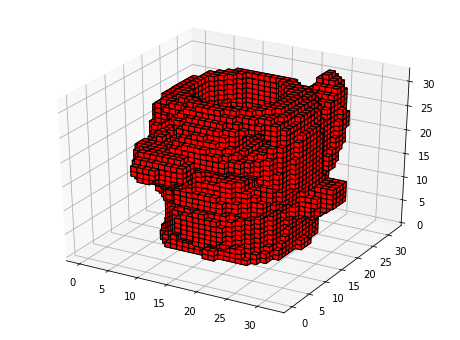

In [22]:
# vox_data = thingi.get_voxels(
#     VOXELS_DIM,
#     stl_file=thingi.get_stl_path(stl_id=101902),
#     shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
# recon = vae.reconstruct(vox_data)
# recon = np.reshape(recon, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
# recon = recon > 0.09
# plot_voxels(recon)

####### mashup two objects ###############3
vox_data_1 = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=101902),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
vox_data_2 = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=299291),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
mashup = vae.mashup(vox_data_1, vox_data_2)
mashup = np.reshape(mashup, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
# mashup = mashup > 0.028
plot_voxels(mashup)

In [23]:
from skimage import measure
output_dir = os.path.join('_output', '3d-vae-gan')
os.makedirs(output_dir, exist_ok=True)
graphs_dir = os.path.join(output_dir, 'graphs')
os.makedirs(graphs_dir, exist_ok=True)

verts, faces, normals, values = measure.marching_cubes_lewiner(mashup, 0)
save_vectors_as_stl(verts[faces], os.path.join(graphs_dir, 'mashup.stl'))

### Insights and Further Tuning
 - 0.1 is a good option for cutoff
 - add clip to discriminator [-0.5, 0.5]
 - use different learning rate/optimization functions for VAE and GAN loss?
 - using smaller learning rate doesn't solve the problem. Perhaps need to check CNN layer parameter.
 - use 64x64x64 as input (Be careful! need to update CNN dimensions!)
 - more iterations
 - latent dimension
 - different data sets
 
 Issues:
 
 1. check the loss function by iteration, change as expected?
 2. after 500 iterations with small data set, total loss is small but the generated object is not good, or worse
 3. inf/-inf loss after many iterations for the animal data of Thingi10k
 4. what does the discriminator output mean [2, 2, 2, 1]?
